<a href="https://colab.research.google.com/github/ChapelFob80930/GenAI-Lab/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers,Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

latent_dim=1024
image_shape=x_train[0].shape
mse_loss=MeanSquaredError()
kl_loss=KLDivergence()

class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta): # Corrected the method name to __init__
        super(VAE, self).__init__() # Calling superclass constructor
        self.latent_dim=latent_dim
        self.image_shape=image_shape
        self.beta=beta # Update initialization with beta value
        #encoder
        self.encoder=tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
            #layers. batch normalization
            layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same', name="Encoder_conv2D_4"),
            layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same', name="Encoder_conv2D_6"),
            #layers.Conv2D(filters=224, kernel_size=3, strides=2, activation='relu', padding='same', name="Encoder_conv2D_8"),
            layers.Flatten(name="Encoder_Flatten"),
        ])
        #reparametirization
        self.z_mean=layers.Dense(latent_dim, name="z_mean")
        self.z_log_var=layers.Dense(latent_dim, name="z_log_var")

        #decoder
        self.decoder=tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8,8,64)),
            layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
            # Adjust strides to match the input image size
            layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid', padding='same'),
        ])

        self.total_loss_tracker=keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker=keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker=keras.metrics.Mean(name="kl_loss")

    def encode(self, data): # Moved encode inside the class
        x = self.encoder(data)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

    def reparameterization(self, z_mean, z_log_var): # Moved reparameterization inside the class
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, x): # Moved call inside the class
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_recon = self.decoder(z)
        return x_recon, mean, log_var

    def decode(self, data): # Moved decode inside the class
        return self.decoder(data)

    # Define metrics as a property instead of a method
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, z_logvar, z_mu):
        kl = -0.5 * tf.reduce_mean(1+ z_logvar - z_mu**2 - tf.math.exp(z_logvar))
        return self.beta*kl

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            kl_loss = self.kl_divergence(z_log_var, z_mean) # Calling kl_divergence as a method
            reconstruction_loss = self.recon_loss(data, reconstruction) # Calling recon_loss as a method
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

vae = VAE(latent_dim,image_shape,0.3)
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping=EarlyStopping(monitor='loss',patience=5,verbose=1)
history=vae.fit(x_train,epochs=10,batch_size=512,callbacks=[early_stopping])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - kl_loss: 7.3272e-04 - loss: 0.6866 - reconstruction_loss: 0.6859
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - kl_loss: 0.0079 - loss: 0.6280 - reconstruction_loss: 0.6201
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - kl_loss: 0.0105 - loss: 0.6197 - reconstruction_loss: 0.6092
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - kl_loss: 0.0121 - loss: 0.6148 - reconstruction_loss: 0.6027
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - kl_loss: 0.0131 - loss: 0.6117 - reconstruction_loss: 0.5986
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - kl_loss: 0.0135 - loss: 0.6107 - reconstruction_loss: 0.5972
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - kl_loss: 0.0140 - loss: 0.6093 - reconstruction_loss: 0.5953
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - kl_loss: 0.0142 - loss: 0.6078 - reconstruction_loss: 0.5935
Epoch 9/10
98/98 ━━━━━━━━━━━━━━

In [ ]:
def generated_images_from_latent_vectors(vae, num_images_to_generate):
  random_latent_vectors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decode(random_latent_vectors)
  return generated_images

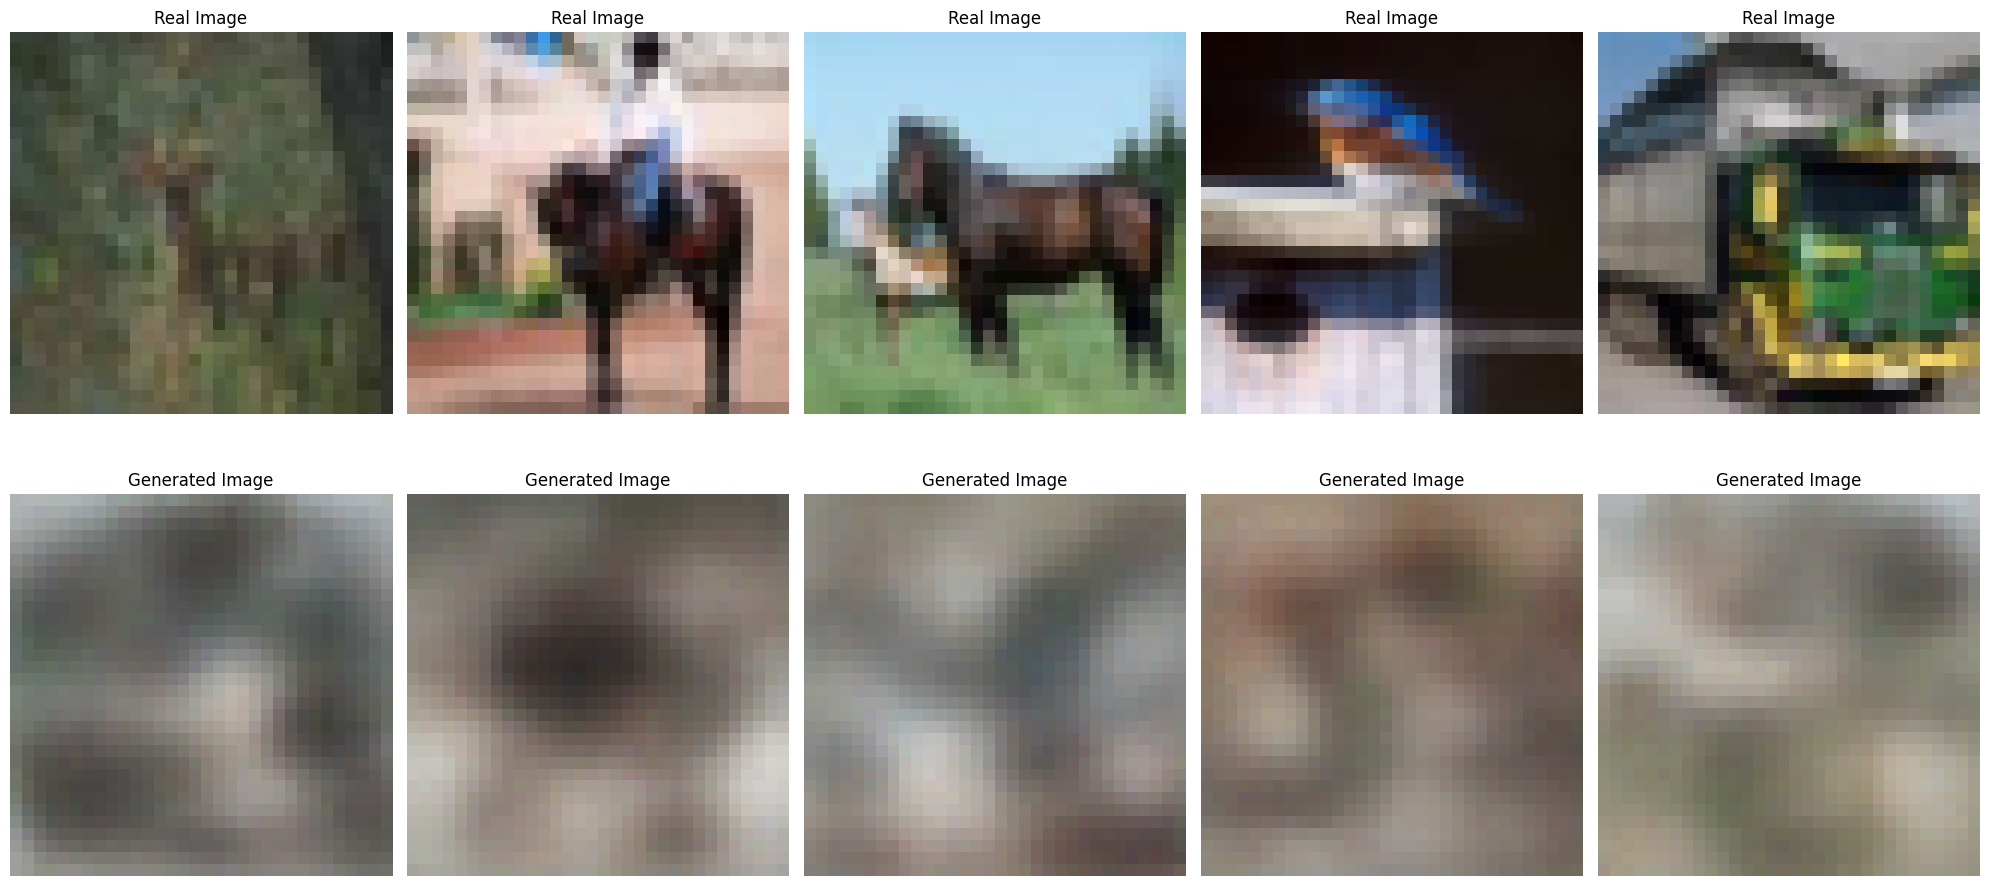

In [ ]:
def generated_images_from_latent_vectors(vae, num_images_to_generate):
  random_latent_vectors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decode(random_latent_vectors)
  return generated_images

# Call the function to generate images and assign the result to generated_images
generated_images = generated_images_from_latent_vectors(vae, 5)  # Generate 5 images

def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
  plt.figure(figsize=(20, 10))
  for i in range(num_images_to_generate):
    plt.subplot(2, num_images_to_generate, i + 1)
    plt.imshow(real_images[i+10])
    plt.title('Real Image')
    plt.axis('off')
  for i in range(num_images_to_generate):
    plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
    plt.imshow(generated_images[i])
    plt.title('Generated Image')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Now call the plotting function with the generated images
plot_real_and_generated_images(x_train, generated_images, 5)


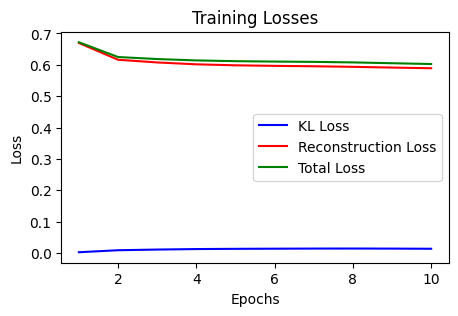

In [ ]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['loss']
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
